Each layer thickness: 50.0 nm
Total stack height: 550.0 nm (11 layers)
Stack positioned from y=0 to y=0.550 µm
Source position: y = 0.950 µm (above stack)
Reflection plane: y = 0.700 µm (above stack)
Transmission plane: y = -0.150 µm (below stack)
Frequency range: 1.429 to 3.333 (1/µm)
Wavelength range: 300 to 700 nm
Gaussian pulse center: 500 nm, width: 1.905 (1/µm)
Starting normalization run (no DBR)...


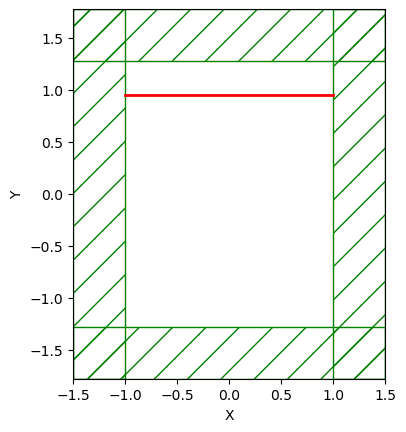

In [1]:
import meep as mp
import numpy as np
import matplotlib.pyplot as plt

resolution = 200  
res_label = f"{resolution} pix/µm"

# DBR layer parameters
layer_thickness = 0.050   
n_layers = 11           
total_stack_height = n_layers * layer_thickness 

print(f"Each layer thickness: {layer_thickness*1000:.1f} nm")
print(f"Total stack height: {total_stack_height*1000:.1f} nm ({n_layers} layers)")

# cell dimensions
sx = 3.0                 # cell width in x
sy = total_stack_height + 3.0  # cell height in y
cell = mp.Vector3(sx, sy, 0)

# PML
dpml = 0.5             # PML thickness
pml_layers = [mp.PML(dpml)]

# wavelength range: 300 nm to 700 nm
lam_min = 0.3            
lam_max = 0.7           
fmax = 1.0 / lam_min     
fmin = 1.0 / lam_max     
fcen = 1/0.5  # center frequency
df = fmax - fmin  # bandwidth

# materials 
n_high = 2.39
n_low  = 1.956338417
eps_high = n_high**2
eps_low  = n_low**2

# alternating vertical stack
geometry = []
for i in range(n_layers):
    y_center = (i + 0.5) * layer_thickness  
    mat_eps = eps_high if (i % 2 == 0) else eps_low
    geometry.append(mp.Block(size=mp.Vector3(mp.inf, layer_thickness, mp.inf),
                             center=mp.Vector3(0, y_center, 0),
                             material=mp.Medium(epsilon=mat_eps)))

print(f"Stack positioned from y=0 to y={total_stack_height:.3f} µm")

# source: Gaussian pulse to excite full wavelength range
# Positioned above the DBR stack
src_y = total_stack_height + 0.4  
sources = [mp.Source(mp.GaussianSource(fcen, fwidth=df),
                     component=mp.Ez,
                     center=mp.Vector3(0, src_y, 0),
                     size=mp.Vector3(sx-2*dpml, 0, 0))]

# flux planes: reflection (between source and stack) and transmission (below stack)
refl_y = total_stack_height + 0.15  # between source and stack top
tran_y = -0.15  # below stack bottom (at y=0)

print(f"Source position: y = {src_y:.3f} µm (above stack)")
print(f"Reflection plane: y = {refl_y:.3f} µm (above stack)")
print(f"Transmission plane: y = {tran_y:.3f} µm (below stack)")
nfreq = 200

# flux regions - lines perpendicular to propagation direction
refl_fr = mp.FluxRegion(center=mp.Vector3(0, refl_y, 0), 
                        size=mp.Vector3(sx-2*dpml, 0, 0))
tran_fr = mp.FluxRegion(center=mp.Vector3(0, tran_y, 0), 
                        size=mp.Vector3(sx-2*dpml, 0, 0))

# probe point
pt = mp.Vector3(0, tran_y, 0)

print(f"Frequency range: {fmin:.3f} to {fmax:.3f} (1/µm)")
print(f"Wavelength range: {lam_min*1e3:.0f} to {lam_max*1e3:.0f} nm")
print(f"Gaussian pulse center: {1/fcen*1e3:.0f} nm, width: {df:.3f} (1/µm)")
print("Starting normalization run (no DBR)...")

# normalization run (no geometry)
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    sources=sources,
                    resolution=resolution)

from matplotlib import pyplot as plt

%matplotlib inline
plt.figure(dpi=100)
sim.plot2D()
plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.003438 s
Working in 2D dimensions.
Computational cell is 3 x 3.55 x 0 with resolution 200
time for set_epsilon = 0.620962 s
-----------
on time step 784 (time=1.96), 0.005103 s/step
on time step 1819 (time=4.5475), 0.00386552 s/step
on time step 2841 (time=7.1025), 0.00391546 s/step
on time step 3794 (time=9.485), 0.00419947 s/step
on time step 4778 (time=11.945), 0.00406771 s/step
on time step 5829 (time=14.5725), 0.00380847 s/step
on time step 6866 (time=17.165), 0.00385853 s/step
on time step 7880 (time=19.7), 0.00394626 s/step
on time step 8871 (time=22.1775), 0.00403787 s/step
on time step 9895 (time=24.7375), 0.0039102 s/step
on time step 10866 (time=27.165), 0.00411968 s/step
on time step 11899 (time=29.7475), 0.00387268 s/step
on time step 12935 (time=32.3375), 0.00386309 s/step
on time step 13927 (time=34.8175), 0.00403308 s/step
on time step 14879 (time=37.1975), 0.00420292 s/step
on time step 15831 (time

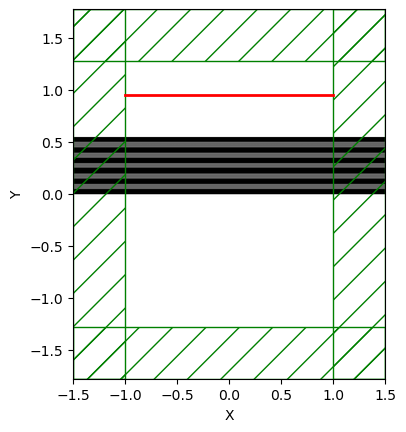

In [2]:

refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# Run until pulse has propagated through and decayed
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# save flux field data and incident power
straight_refl_data = sim.get_flux_data(refl)
straight_tran_flux = np.array(mp.get_fluxes(tran))

print("Normalization run complete.")
print("Starting DBR simulation...")

sim.reset_meep()

#run with DBR geometry
sim = mp.Simulation(cell_size=cell,
                    boundary_layers=pml_layers,
                    geometry=geometry,
                    sources=sources,
                    resolution=resolution)

from matplotlib import pyplot as plt

%matplotlib inline
plt.figure(dpi=100)
sim.plot2D()
plt.show()


-----------
Initializing structure...
time for choose_chunkdivision = 0.000436068 s
Working in 2D dimensions.
Computational cell is 3 x 3.55 x 0 with resolution 200
     block, center = (0,0.025,0)
          size (1e+20,0.05,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7121,5.7121,5.7121)
     block, center = (0,0.075,0)
          size (1e+20,0.05,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.35622,3.35622,3.35622)
     block, center = (0,0.125,0)
          size (1e+20,0.05,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (5.7121,5.7121,5.7121)
     block, center = (0,0.175,0)
          size (1e+20,0.05,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
          dielectric constant epsilon diagonal = (3.35622,3.35622,3.35622)
     block, center = (0,0.225,0)
          size (1e+20,0.05,1e+20)
          axes (1,0,0), (0,1,0), (0,0,1)
 

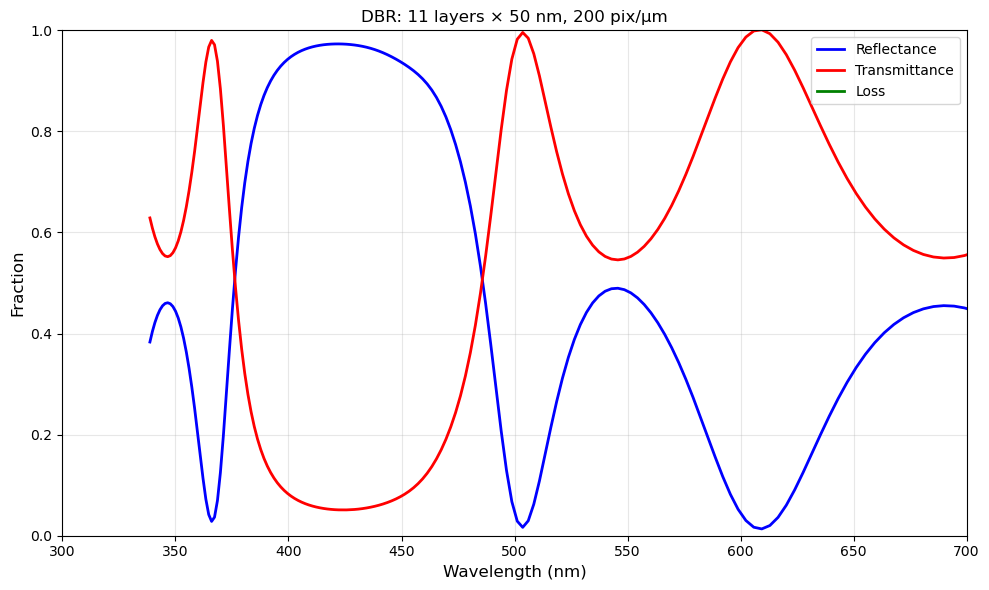


Results at key wavelengths:
  λ = 399.6 nm: R=0.943, T=0.084, Loss=-0.026
  λ = 498.8 nm: R=0.067, T=0.943, Loss=-0.011
  λ = 598.9 nm: R=0.052, T=0.966, Loss=-0.018

Peak reflectance: R=0.973 at λ=422.2 nm


In [ ]:

refl = sim.add_flux(fcen, df, nfreq, refl_fr)
tran = sim.add_flux(fcen, df, nfreq, tran_fr)

# load negated incident fields for reflection measurement
sim.load_minus_flux_data(refl, straight_refl_data)

# Run until pulse has propagated through and decayed
sim.run(until_after_sources=mp.stop_when_fields_decayed(50, mp.Ez, pt, 1e-3))

# get flux data
dbr_refl_flux = np.array(mp.get_fluxes(refl))
dbr_tran_flux = np.array(mp.get_fluxes(tran))
freqs = np.array(mp.get_flux_freqs(refl))

print("DBR simulation complete.")

# compute reflectance, transmittance, and loss
wls = 1.0 / freqs  # wavelengths in µm

R = -dbr_refl_flux / straight_tran_flux  
T = dbr_tran_flux / straight_tran_flux
Loss = 1 - R - T

# plotting
if mp.am_master():
    plt.figure(figsize=(10, 6))
    plt.plot(wls*1e3, R, 'b-', label='Reflectance', linewidth=2)
    plt.plot(wls*1e3, T, 'r-', label='Transmittance', linewidth=2)
    plt.plot(wls*1e3, Loss, 'g-', label='Loss', linewidth=2)
    plt.xlabel('Wavelength (nm)', fontsize=12)
    plt.ylabel('Fraction', fontsize=12)
    plt.title(f"DBR: {n_layers} layers × {layer_thickness*1000:.0f} nm, {res_label}", fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.xlim(300, 700)
    plt.ylim(0, 1)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    #plt.savefig('dbr_reflectance_sweep.png', dpi=150)
    plt.show()
    
    # diagnostic info at regular intervals
    print(f"\nResults at key wavelengths:")
    for target_wl in [400, 500, 600]:
        idx = np.argmin(np.abs(wls*1e3 - target_wl))
        actual_wl = wls[idx]*1e3
        print(f"  λ = {actual_wl:.1f} nm: R={R[idx]:.3f}, T={T[idx]:.3f}, Loss={Loss[idx]:.3f}")
    
    # Find peak reflectance
    max_R_idx = np.argmax(R)
    print(f"\nPeak reflectance: R={R[max_R_idx]:.3f} at λ={wls[max_R_idx]*1e3:.1f} nm")